# Swin Transformers

This notebook trains a  Vision Transformer on the Butterfly dataset.

In [1]:
import os
import random
import numpy as np
import torch


def set_seed(seed):

    random.seed(seed)     # python random generator
    np.random.seed(seed)  # numpy random generator

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    
set_seed(42)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# We use a butterfly dataset of 50 species to demonstrate the classification method

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [4]:
## Now, we import timm, torchvision image models
# !pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

/Users/asmitganguly/miniconda3/envs/mlx/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import sys
from tqdm import tqdm
import time
import copy

In [8]:
# def get_classes(data_dir):
#     all_data = datasets.ImageFolder(data_dir)
#     return all_data.classes

In [9]:
# def get_data_loaders(data_dir, batch_size, train = False):
#     if train:
#         #train
#         transform = T.Compose([
#             T.RandomHorizontalFlip(),
#             T.RandomVerticalFlip(),
#             T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
#             T.Resize(256),
#             T.CenterCrop(224),
#             T.ToTensor(),
#             T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
#             T.RandomErasing(p=0.1, value='random')
#         ])
#         train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
#         train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
#         return train_loader, len(train_data)
#     else:
#         # val/test
#         transform = T.Compose([ # We dont need augmentation for test transforms
#             T.Resize(256),
#             T.CenterCrop(224),
#             T.ToTensor(),
#             T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
#         ])
#         val_data = datasets.ImageFolder(os.path.join(data_dir, "valid/"), transform=transform)
#         test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
#         val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
#         test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
#         return val_loader, test_loader, len(val_data), len(test_data)

In [10]:
# dataset_path = "/kaggle/input/butterfly-images40-species/"

In [11]:
# (train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
# (val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [12]:
# classes = get_classes("/kaggle/input/butterfly-images40-species/train/")
# print(classes, len(classes))

In [13]:
# dataloaders = {
#     "train": train_loader,
#     "val": val_loader
# }
# dataset_sizes = {
#     "train": train_data_len,
#     "val": valid_data_len
# }

In [14]:
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
classes = list(pd.read_csv("/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv")["class"].unique())
# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        
        classes = list(pd.read_csv("/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv")["class"].unique())

        # Initialize the label encoder
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(classes)

        # Initialize the one hot encoder
        onehot_encoder = OneHotEncoder(sparse_output=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

        # Create a dictionary to map the classes to the one hot encoding
        class_dict = {}
        for i in range(len(classes)):
            class_dict[classes[i]] = onehot_encoded[i]
            
        self.class_dict = class_dict

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_frame.iloc[idx]['path'])
        image = Image.open(img_name).convert('RGB')
        label = self.data_frame.iloc[idx]['class']
        
        if self.transform:
            image = self.transform(image)

        return image, self.class_dict[label]

# Define the transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
])

# Initialize the dataset
TrainDataset = CustomImageDataset(csv_file='/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv', transform=data_transforms)
TestDataset = CustomImageDataset(csv_file='/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/test_data.csv', transform=data_transforms)

print(TrainDataset.__getitem__(0))
print(TestDataset.__getitem__(1))


train_loader = DataLoader(TrainDataset, batch_size=4)
val_loader = DataLoader(TestDataset, batch_size=4)
test_loader = DataLoader(TestDataset, batch_size=4)

(tensor([[[-2.1179, -2.1179, -2.1008,  ..., -1.5185, -1.5357, -1.5014],
         [-2.0494, -2.0494, -2.0665,  ..., -1.5014, -1.5357, -1.5870],
         [-1.7925, -1.7583, -1.7925,  ..., -1.4329, -1.4329, -1.5528],
         ...,
         [-1.5185, -1.5185, -1.5528,  ..., -1.5528, -1.5014, -1.5014],
         [-1.5185, -1.4329, -1.5357,  ..., -1.4500, -1.5014, -1.5185],
         [-1.5528, -1.4672, -1.5185,  ..., -1.4500, -1.3815, -1.4672]],

        [[-2.0357, -2.0357, -2.0182,  ..., -1.4230, -1.4405, -1.4055],
         [-1.9657, -1.9657, -1.9832,  ..., -1.4055, -1.4405, -1.4930],
         [-1.7031, -1.6681, -1.7031,  ..., -1.3354, -1.3354, -1.4580],
         ...,
         [-1.4230, -1.4230, -1.4580,  ..., -1.4580, -1.4055, -1.4055],
         [-1.4230, -1.3354, -1.4405,  ..., -1.3529, -1.4055, -1.4230],
         [-1.4580, -1.3704, -1.4230,  ..., -1.3529, -1.2829, -1.3704]],

        [[-1.8044, -1.8044, -1.7870,  ..., -1.1944, -1.2119, -1.1770],
         [-1.7347, -1.7347, -1.7522,  ..., -

In [15]:
print(len(train_loader), len(val_loader), len(test_loader))

115 29 29


In [16]:
# print(train_data_len, valid_data_len, test_data_len)

In [17]:
# now, for the model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [18]:
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
# check hubconf for more models.
model_feature = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) # load from torch hub

Using cache found in /Users/asmitganguly/.cache/torch/hub/SharanSMenon_swin-transformer-hub_main


In [19]:
from kan import KAN

class KAN_class(nn.Module):
    def __init__(self):
        super(KAN_class, self).__init__()
        self.kan1 = KAN(
            width=[50,5],
            grid=10,
            k=3,
            noise_scale=0.01,
            scale_base_mu=1,
            scale_base_sigma=1,
            grid_eps=0.02,
            grid_range=[0,1])
        

    def forward(self, x):
        x = self.kan1(x)

        x = F.log_softmax(x, dim=1)
        return x

In [20]:
for param in model_feature.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model_feature.head.in_features
model_feature.head = nn.Sequential(
    nn.Linear(n_inputs, 50),
    # nn.ReLU(),
    # nn.Dropout(0.3),
    # nn.Linear(512, 5)
)
model_feature = model_feature.to(device)
print(model_feature.head)

Sequential(
  (0): Linear(in_features=768, out_features=50, bias=True)
)


In [21]:
# model_feature = model
model_feature.to(device)
model_class = KAN_class().to(device)

# out = model_class(model_feature.feature(tt.to(device)))
# print("out: ", out.shape)

#new model as the mix of both the models
class MixModel(nn.Module):
    def __init__(self, model_feature, model_class):
        super(MixModel, self).__init__()
        self.model_feature = model_feature
        self.model_class = model_class
        
    def forward(self, x):
        x = self.model_feature(x)
        x = self.model_class(x)
        return x
    def get_feat(self, x):
        return self.model_feature(x)
    def get_act_l0(self, x):
        return self.model_feature.conv1(x)
    
model = MixModel(model_feature, model_class).to(device)

checkpoint directory created: ./model
saving model version 0.0


In [22]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
# optimizer = optim.AdamW([model.model_feature.head.parameters(), model.model_class.parameters()], lr=0.001)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

43200

In [80]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [84]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, chk=None):
    if chk is not None:
        model.load_state_dict(torch.load(chk, map_location=device))
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            if phase == 'train':
                loader = train_loader
            else:
                loader = val_loader
                
            for inputs, labels in tqdm(loader):
                inputs = inputs.to(torch.float32).to(device)
                labels = labels.argmax(dim=1).to(torch.int64).to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / (len(loader)*4)
            epoch_acc =  running_corrects.float() / (len(loader)*4)
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
                torch.save(model.state_dict(), "./weights/swin-kan-best_model_swin.pth")
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [85]:
DO_train=True

In [89]:
if DO_train:
    model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=30) # now it is a lot faster
    # I will come back after 10 epochs
# model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10) # now it is a lot faster
# I will come back after 10 epochs
else:
    model_ft = torch.load("./weights/swin-kan-best_model_swin.pth", map_location=device)

Epoch 0/29
----------


100%|██████████| 115/115 [00:34<00:00,  3.38it/s]


train Loss: 0.5940 Acc: 0.9326


100%|██████████| 29/29 [00:04<00:00,  6.94it/s]


val Loss: 0.6586 Acc: 0.8966

Epoch 1/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.51it/s]


train Loss: 0.5783 Acc: 0.9261


100%|██████████| 29/29 [00:04<00:00,  7.04it/s]


val Loss: 0.6617 Acc: 0.8966

Epoch 2/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.56it/s]


train Loss: 0.5662 Acc: 0.9391


100%|██████████| 29/29 [00:04<00:00,  6.96it/s]


val Loss: 0.6568 Acc: 0.9052

Epoch 3/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.57it/s]


train Loss: 0.5708 Acc: 0.9435


100%|██████████| 29/29 [00:04<00:00,  6.98it/s]


val Loss: 0.6230 Acc: 0.9224

Epoch 4/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.57it/s]


train Loss: 0.5543 Acc: 0.9239


100%|██████████| 29/29 [00:04<00:00,  7.04it/s]


val Loss: 0.6425 Acc: 0.8879

Epoch 5/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.57it/s]


train Loss: 0.5422 Acc: 0.9522


100%|██████████| 29/29 [00:03<00:00,  7.28it/s]


val Loss: 0.6195 Acc: 0.8966

Epoch 6/29
----------


100%|██████████| 115/115 [00:31<00:00,  3.63it/s]


train Loss: 0.5305 Acc: 0.9565


100%|██████████| 29/29 [00:04<00:00,  7.04it/s]


val Loss: 0.6399 Acc: 0.8879

Epoch 7/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.57it/s]


train Loss: 0.5243 Acc: 0.9609


100%|██████████| 29/29 [00:04<00:00,  6.97it/s]


val Loss: 0.6636 Acc: 0.8793

Epoch 8/29
----------


100%|██████████| 115/115 [00:33<00:00,  3.47it/s]


train Loss: 0.5282 Acc: 0.9630


100%|██████████| 29/29 [00:04<00:00,  6.97it/s]


val Loss: 0.6254 Acc: 0.8966

Epoch 9/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.49it/s]


train Loss: 0.5270 Acc: 0.9587


100%|██████████| 29/29 [00:04<00:00,  6.84it/s]


val Loss: 0.6712 Acc: 0.8707

Epoch 10/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.53it/s]


train Loss: 0.5281 Acc: 0.9522


100%|██████████| 29/29 [00:04<00:00,  7.00it/s]


val Loss: 0.6350 Acc: 0.8621

Epoch 11/29
----------


100%|██████████| 115/115 [00:33<00:00,  3.40it/s]


train Loss: 0.5132 Acc: 0.9630


100%|██████████| 29/29 [00:04<00:00,  6.90it/s]


val Loss: 0.6381 Acc: 0.8793

Epoch 12/29
----------


100%|██████████| 115/115 [00:33<00:00,  3.40it/s]


train Loss: 0.5108 Acc: 0.9609


100%|██████████| 29/29 [00:04<00:00,  7.01it/s]


val Loss: 0.6325 Acc: 0.9052

Epoch 13/29
----------


100%|██████████| 115/115 [00:34<00:00,  3.33it/s]


train Loss: 0.4988 Acc: 0.9674


100%|██████████| 29/29 [00:04<00:00,  6.76it/s]


val Loss: 0.5915 Acc: 0.9052

Epoch 14/29
----------


100%|██████████| 115/115 [00:33<00:00,  3.48it/s]


train Loss: 0.4985 Acc: 0.9696


100%|██████████| 29/29 [00:04<00:00,  6.65it/s]


val Loss: 0.5861 Acc: 0.9052

Epoch 15/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.50it/s]


train Loss: 0.5092 Acc: 0.9696


100%|██████████| 29/29 [00:04<00:00,  7.02it/s]


val Loss: 0.6110 Acc: 0.9052

Epoch 16/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.57it/s]


train Loss: 0.4897 Acc: 0.9652


100%|██████████| 29/29 [00:04<00:00,  7.09it/s]


val Loss: 0.7019 Acc: 0.8793

Epoch 17/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.52it/s]


train Loss: 0.4970 Acc: 0.9739


100%|██████████| 29/29 [00:04<00:00,  6.99it/s]


val Loss: 0.6050 Acc: 0.9224

Epoch 18/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.56it/s]


train Loss: 0.4906 Acc: 0.9652


100%|██████████| 29/29 [00:04<00:00,  7.04it/s]


val Loss: 0.5868 Acc: 0.9310

Epoch 19/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.56it/s]


train Loss: 0.4875 Acc: 0.9696


100%|██████████| 29/29 [00:04<00:00,  7.11it/s]


val Loss: 0.5968 Acc: 0.9052

Epoch 20/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.50it/s]


train Loss: 0.5007 Acc: 0.9674


100%|██████████| 29/29 [00:04<00:00,  7.05it/s]


val Loss: 0.6312 Acc: 0.9310

Epoch 21/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.55it/s]


train Loss: 0.4829 Acc: 0.9761


100%|██████████| 29/29 [00:04<00:00,  7.06it/s]


val Loss: 0.6433 Acc: 0.8966

Epoch 22/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.49it/s]


train Loss: 0.4915 Acc: 0.9717


100%|██████████| 29/29 [00:04<00:00,  7.01it/s]


val Loss: 0.5997 Acc: 0.9138

Epoch 23/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.54it/s]


train Loss: 0.4776 Acc: 0.9848


100%|██████████| 29/29 [00:04<00:00,  7.10it/s]


val Loss: 0.6169 Acc: 0.9052

Epoch 24/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.49it/s]


train Loss: 0.4974 Acc: 0.9696


100%|██████████| 29/29 [00:04<00:00,  6.97it/s]


val Loss: 0.6263 Acc: 0.9138

Epoch 25/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.53it/s]


train Loss: 0.4723 Acc: 0.9826


100%|██████████| 29/29 [00:05<00:00,  5.73it/s]


val Loss: 0.6140 Acc: 0.9224

Epoch 26/29
----------


100%|██████████| 115/115 [00:33<00:00,  3.47it/s]


train Loss: 0.4728 Acc: 0.9826


100%|██████████| 29/29 [00:04<00:00,  7.08it/s]


val Loss: 0.6120 Acc: 0.8966

Epoch 27/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.55it/s]


train Loss: 0.4730 Acc: 0.9826


100%|██████████| 29/29 [00:04<00:00,  7.10it/s]


val Loss: 0.6030 Acc: 0.9138

Epoch 28/29
----------


100%|██████████| 115/115 [00:32<00:00,  3.55it/s]


train Loss: 0.4669 Acc: 0.9848


100%|██████████| 29/29 [00:04<00:00,  7.12it/s]


val Loss: 0.6270 Acc: 0.9052

Epoch 29/29
----------


100%|██████████| 115/115 [00:33<00:00,  3.48it/s]


train Loss: 0.4658 Acc: 0.9804


100%|██████████| 29/29 [00:04<00:00,  7.04it/s]

val Loss: 0.6140 Acc: 0.8879

Training complete in 18m 29s
Best Val Acc: 0.9310


## Testing

Ok, now we finished training. Lets run the dataset on the test loader and calculate accuracy

In [90]:
test_loss = 0.0
classes = list(pd.read_csv("/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv")["class"].unique())
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(torch.float32).to(device), target.argmax(dim=1).to(torch.int64).to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # print(len(target))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss / (len(test_loader)*4)
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 29/29 [00:04<00:00,  6.86it/s]

Test Loss: 0.0130
Test Accuracy of Age_related_Macular_Degeneration: 81% ( 9/11)
Test Accuracy of Central_serous: 85% (18/21)
Test Accuracy of Diabetic: 100% (22/22)
Test Accuracy of Macular_Hole: 85% (17/20)
Test Accuracy of Normal: 100% (41/41)
Test Accuracy of 93% (107/115)


# TEST

Training for 1 epochs on mps
Valid accuracy: 93.04
Test Accuracy of Age_related_Macular_Degeneration: 81% ( 9/11)
Test Accuracy of Central_serous: 85% (18/21)
Test Accuracy of Diabetic: 100% (22/22)
Test Accuracy of Macular_Hole: 85% (17/20)
Test Accuracy of Normal: 100% (41/41)
Test Accuracy of 93% (107/115)
Total training time: 4.4 seconds


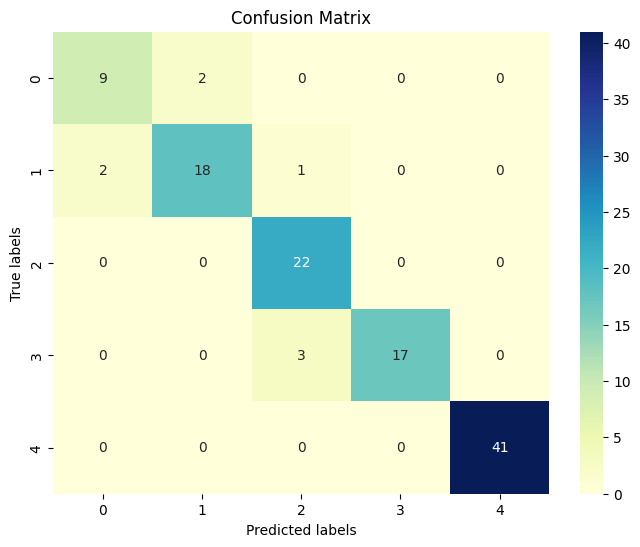

In [91]:
import time
from sklearn.metrics import precision_score, recall_score, f1_score

def test(net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None, epochs=10, device='mps', checkpoint_epochs=10):
    classes = list(pd.read_csv("/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv")["class"].unique())
    class_correct = list(0 for i in range(len(classes)))
    class_total = list(0 for i in range(len(classes)))
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')
    results = {
        'precision': [],
        'recall': [],
        'f1': [],
        'predictions': [],
        'targets': []
    }
    if valid_dataloader is not None:
        net.eval()  # put network in train mode for Dropout and Batch Normalization
        valid_loss = torch.tensor(0., device=device)
        valid_accuracy = torch.tensor(0., device=device)
        with torch.no_grad():
            for X, y in valid_dataloader:
                X = X.to(torch.float32).to(device)
                y = y.to(torch.float32).to(device)
                target = y.argmax(dim=1).to(torch.int64).to(device)
                preds = net(X)
                # print(preds.shape, y.shape)
                # loss = criterion(preds, y)
                _, pred = torch.max(preds, 1)
                # print(pred)
                # print(target)
                # print(y)
                correct_tensor = pred.eq(target.data.view_as(pred))
                correct = np.squeeze(correct_tensor.cpu().numpy())
                # print(len(target))
                # print(len(y))
                for i in range(len(y)):
                    label = target.data[i]
                    class_correct[label] += correct[i].item()
                    class_total[label] += 1

            
                
                
                # valid_loss += loss * valid_dataloader.batch_size
                valid_accuracy += (torch.argmax(preds, dim=1) == torch.argmax(y, dim=1)).sum()
                
                all_predictions = torch.argmax(preds, dim=1).cpu().numpy()
                all_targets = torch.argmax(y, dim=1).cpu().numpy()
                precision = precision_score(all_targets, all_predictions, average=None)
                recall = recall_score(all_targets, all_predictions, average=None)
                f1 = f1_score(all_targets, all_predictions, average=None)
                
                results['precision'].append(precision)
                results['recall'].append(recall)
                results['f1'].append(f1)
                results['predictions'].append(all_predictions)
                results['targets'].append(all_targets)
    
    if valid_dataloader is not None:
        # print(f'Valid loss: {valid_loss/len(valid_dataloader.dataset):.2f}')
        print(f'Valid accuracy: {100*valid_accuracy/len(valid_dataloader.dataset):.2f}')
    for i in range(len(classes)):
        if class_total[i] > 0:
            print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
                classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
            ))
        else:
            print("Test accuracy of %5s: NA" % (classes[i]))
    print("Test Accuracy of %2d%% (%2d/%2d)" % (
                100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
            ))
    
    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net, results

net, results = test(model_ft, train_loader, val_loader, criterion, optimizer, None, 1, device)
# print(results)


result_final = {
    'precision': [],
    'recall': [],
    'f1': [],
    'predictions': [],
    'targets': []
}

for k in results.keys():
    for ll in results[k]:
        for ele in ll:
            result_final[k].append(ele)
            
# print(result_final)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(result_final["targets"], result_final["predictions"])

# display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [27]:
# # our model earns 93% test accuracy, which is very high. lets save it
# example = torch.rand(1, 3, 224, 224)
# traced_script_module = torch.jit.trace(model.cpu(), example)
# traced_script_module.save("./weights/trace_butterfly_swin_transformer.pt")

In [92]:
for param in net.parameters(): #freeze model
    param.requires_grad = True

In [97]:
model == net

True

In [94]:
net.model_feature.layers[-1].blocks[-1].norm1

LayerNorm((768,), eps=1e-05, elementwise_affine=True)

In [29]:
model.layers[-1].blocks[-1].norm1

LayerNorm((768,), eps=1e-05, elementwise_affine=True)

In [98]:
import argparse
import cv2
import numpy as np
import torch
import timm

from pytorch_grad_cam import (
    GradCAM, ScoreCAM, GradCAMPlusPlus, 
    AblationCAM, XGradCAM, EigenCAM, 
    EigenGradCAM, LayerCAM, FullGrad
)
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit

def visualize_cam(image_path, method='scorecam', use_cuda=False, 
                  aug_smooth=False, eigen_smooth=False):
    """
    Visualize CAM for a given image using specified method
    
    Parameters:
    - image_path: Path to the input image
    - method: CAM visualization method (default: 'scorecam')
    - use_cuda: Use GPU acceleration (default: False)
    - aug_smooth: Apply test time augmentation (default: False)
    - eigen_smooth: Reduce noise using first principle component (default: False)
    """
    methods = {
        "gradcam": GradCAM,
        "scorecam": ScoreCAM,
        "gradcam++": GradCAMPlusPlus,
        "ablationcam": AblationCAM,
        "xgradcam": XGradCAM,
        "eigencam": EigenCAM,
        "eigengradcam": EigenGradCAM,
        "layercam": LayerCAM,
        "fullgrad": FullGrad
    }
    
    # Validate method
    if method.lower() not in methods:
        raise ValueError(f"Method must be one of {list(methods.keys())}")
    
    # Model setup
    # model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
    # model = net
    # global model
    global net
    net.eval()
    # model.eval()
    
    # CUDA setup
    use_cuda = use_cuda and torch.cuda.is_available()
    if use_cuda:
        print('Using GPU for acceleration')
        net = net.cuda()
        # model = model.cuda()
    else:
        print('Using CPU for computation')
    
    # Target layers for CAM
    target_layers = [net.model_feature.layers[-1].blocks[-1].norm2]
    # target_layers = [model.layers[-1].blocks[-1].norm2]
    
    # CAM method setup
    if method.lower() == "ablationcam":
        cam = methods[method.lower()](
            model=net,
            # model=model,
            target_layers=target_layers,
            reshape_transform=reshape_transform,
            ablation_layer=AblationLayerVit()
        )
    else:
        cam = methods[method.lower()](
            model=net,
            # model=model,
            target_layers=target_layers,
            reshape_transform=reshape_transform
        )
    
    # Image preprocessing
    rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255
    
    input_tensor = preprocess_image(
        rgb_img, 
        mean=[0.5, 0.5, 0.5], 
        std=[0.5, 0.5, 0.5]
    )
    
    # Set batch size
    cam.batch_size = 32
    
    # Generate CAM
    grayscale_cam = cam(
        input_tensor=input_tensor,
        targets=None,
        eigen_smooth=eigen_smooth,
        aug_smooth=aug_smooth
    )
    
    # Process CAM
    grayscale_cam = grayscale_cam[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam)
    
    return cam_image

def reshape_transform(tensor, height=7, width=7):
    """
    Reshape and transpose tensor for CAM visualization
    """
    result = tensor.reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# Example usage in Jupyter Notebook
# visualize_cam('./examples/both.png', method='gradcam', use_cuda=True)

Using CPU for computation


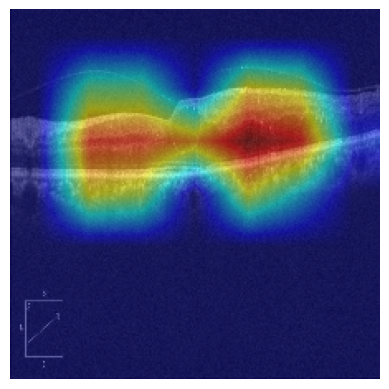

In [99]:
cam_image = visualize_cam('/Users/asmitganguly/Developer/internships/UWaterloo-24/Data/Diabetic/DR2.jpeg', method='eigencam')
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Using CPU for computation


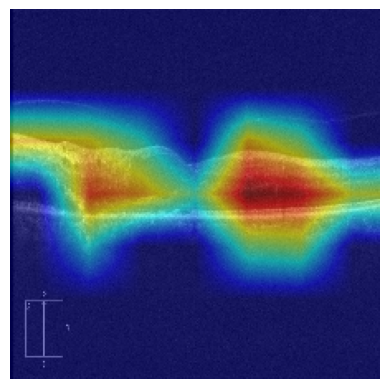

In [100]:
cam_image = visualize_cam('/Users/asmitganguly/Developer/internships/UWaterloo-24/Data/Diabetic/DR1.jpeg', method='eigencam')
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()